# This Notebook is for analyzing and processing the output of scrap in GCP

Context: Given the significant number of jobs on the LinkedIn site, it isn't easy to do an accurate search.
The search needs to be more precise, even with the site's filters.
With this, we captured this data to develop more precise ways of searching for the perfect match job.  


Solution: Scrap all job data on the LinkedIn site automatically. After collecting the data, try to develop a way to improve the search for relevant opportunities in a personalized way for each profile.  


# Libs

In [12]:
import pandas as pd
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import gensim
from gensim import corpora

c:\Users\55249\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
import nltk

In [13]:
import pandas_gbq
from google.oauth2 import service_account

from google.cloud import bigquery
%load_ext google.cloud.bigquery

from google.oauth2 import service_account

# Create BigQuery table for save data scraped

In [3]:
credentials = service_account.Credentials.from_service_account_file( 'teste-315517-6ebeb5337f4a.json', )    
pandas_gbq.context.credentials = credentials

In [4]:
project_id = 'teste-315517'
bigquery_client = bigquery.Client(credentials= credentials,project=project_id)

In [6]:
import datetime

In [8]:
now_datetime = datetime.datetime.now()
print(now_datetime)

2023-04-16 17:25:58.476962


In [11]:
schema_scrp=[
    bigquery.SchemaField("title", "STRING"),
    bigquery.SchemaField("location", "STRING"),
    bigquery.SchemaField("company_name", "STRING"),
    bigquery.SchemaField("position_name", "STRING"),
    bigquery.SchemaField("experience_required", "STRING"),
    bigquery.SchemaField("contract_type", "STRING"),
    bigquery.SchemaField("function_name", "STRING"),
    bigquery.SchemaField("company_sector", "STRING"),
    bigquery.SchemaField("description", "STRING"),
    bigquery.SchemaField("link", "STRING"),
    bigquery.SchemaField("now_datetime", "STRING")
]

In [12]:
#criando tabela no bq cpf
table_id = 'teste-315517.teste.raw_from_linkedin'

table = bigquery.Table(table_id, schema=schema_scrp)
table = bigquery_client.create_table(table)  # Make an API request.
print(
    "Created table {}.{}.{}".format(table.project, table.dataset_id, table.table_id)
)

Created table teste-315517.teste.raw_from_linkedin


# Functions

In [14]:
def clean_column_strings(df):
    """Clean each column of a dirty dataframe

    Args:
        df (dataframe): dataframe to be clean

    Returns:
        dataframe: cleaned dataframe
    """
    
    df['location'] = df['location'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_name'] = df['company_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['experience_required'] = df['experience_required'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['contract_type'] = df['contract_type'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['function_name'] = df['function_name'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    df['company_sector'] = df['company_sector'].apply(lambda x: x.replace("\n", "").strip() if type(x) == str else x)
    clean = re.compile('<.*?>')
    df['description'] = df['description'].apply(lambda x: re.sub(clean, '', x).replace('\n','').strip())
    df['description'] = df['description'].apply(lambda x: word_split(x))
    
    return df

In [15]:
def word_split(text):
    """Split some words that are imprecisaly toguether after scrap

    Args:
        text (string): string to process

    Returns:
        string: string processed
    """
    # replaces each uppercase letter with a space followed by the same lower case letter
    #text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    text = re.sub('<[^<]+?>', '', text)

    return text.strip()



In [16]:
def calculate_na_proportion(df):
    """Build a dataframe with some information about null values on the dataframe

    Args:
        df (dataframe): dataframe to calculate

    Returns:
        dataframe: dataframe with null proportions
    """

    # exploratory DF with % NA and types values
    na_proportion = pd.DataFrame({'name' : df.columns, 'type' : df.dtypes,
                            'NA #': df.isna().sum(), 'NA %' : (df.isna().sum() / df.shape[0]) * 100})
    return na_proportion

# Loading data

In [17]:
credentials = service_account.Credentials.from_service_account_file(
    'teste-315517-6ebeb5337f4a.json',
)
pandas_gbq.context.credentials = credentials

sql = """
SELECT 
*
 FROM `teste-315517.teste.raw_from_linkedin`
  """

# Run a Standard SQL query with the project set explicitly
project_id = 'teste-315517'
df = pd.read_gbq(sql, project_id=project_id, dialect='standard')

In [18]:
df_raw_bigquery = df.copy()

### Clean durty data

In [19]:
df_job = clean_column_strings(df_raw_bigquery)

In [20]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?SandboxAQ is solving ...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2648,Clinical Senior Data Scientist - Nationwide,"Ohio, United States",Cardinal Health,Clinical Senior Data Scientist - Nationwide,Mid-Senior level,Full-time,Engineering and Information Technology,"Medical Equipment Manufacturing, Transportatio...",Fuse is on a mission to disrupt healthcare. Ou...,https://www.linkedin.com/jobs/view/3613563752,2023-06-15 03:20:33.057543
2649,Staff Data Scientist,Greater Pittsburgh Region,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form EnergyAre you ready to rise to the ...,https://www.linkedin.com/jobs/view/3633536830,2023-06-17 03:23:01.588959
2650,Staff Data Scientist,San Francisco Bay Area,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form EnergyAre you ready to rise to the ...,https://www.linkedin.com/jobs/view/3633536819,2023-06-17 03:29:18.570016
2651,Staff Data Scientist,Greater Boston,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form EnergyAre you ready to rise to the ...,https://www.linkedin.com/jobs/view/3633542060,2023-06-17 03:27:41.159125


# Data job Analysis

In [ ]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [17]:
df_job

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?Sandbox AQ is solving...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2648,Clinical Senior Data Scientist - Nationwide,"Ohio, United States",Cardinal Health,Clinical Senior Data Scientist - Nationwide,Mid-Senior level,Full-time,Engineering and Information Technology,"Medical Equipment Manufacturing, Transportatio...",Fuse is on a mission to disrupt healthcare. Ou...,https://www.linkedin.com/jobs/view/3613563752,2023-06-15 03:20:33.057543
2649,Staff Data Scientist,Greater Pittsburgh Region,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536830,2023-06-17 03:23:01.588959
2650,Staff Data Scientist,San Francisco Bay Area,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536819,2023-06-17 03:29:18.570016
2651,Staff Data Scientist,Greater Boston,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633542060,2023-06-17 03:27:41.159125


In [18]:
key_word_ml = 'learning'
key_word_ds = 'scientist'


# check if a column contain a word
ml_patern = re.compile(rf'\b{re.escape(key_word_ml)}\b', flags=re.IGNORECASE)
ds_patern = re.compile(rf'\b{re.escape(key_word_ds)}\b', flags=re.IGNORECASE)

In [19]:
df_target = df_job.loc[(df_job['position_name'].str.contains(ds_patern)) | (df_job['position_name'].str.contains(ml_patern)) ]

In [20]:
#df_target.to_csv('../data/wrangle/df_target.csv',index=False)

In [21]:
total_number_of_targets_scraped =df_target.count()[0]
total_number_of_targets_scraped

2103

In [22]:
total_number_of_data_scraped = df_job.count()[0]
total_number_of_data_scraped

2653

In [23]:
#proportion of durty data scraped
(total_number_of_data_scraped - total_number_of_targets_scraped) / total_number_of_data_scraped

0.20731247644176404

The targets that have the best matches are in the first positions, but Linkedin sends a lot of unrelated jobs after that that are noncorrelated to the target search

In [24]:
# positions names related with target
df_target

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,Duties We encourage you to read this entire va...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?Sandbox AQ is solving...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690
...,...,...,...,...,...,...,...,...,...,...,...
2648,Clinical Senior Data Scientist - Nationwide,"Ohio, United States",Cardinal Health,Clinical Senior Data Scientist - Nationwide,Mid-Senior level,Full-time,Engineering and Information Technology,"Medical Equipment Manufacturing, Transportatio...",Fuse is on a mission to disrupt healthcare. Ou...,https://www.linkedin.com/jobs/view/3613563752,2023-06-15 03:20:33.057543
2649,Staff Data Scientist,Greater Pittsburgh Region,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536830,2023-06-17 03:23:01.588959
2650,Staff Data Scientist,San Francisco Bay Area,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633536819,2023-06-17 03:29:18.570016
2651,Staff Data Scientist,Greater Boston,Form Energy,Staff Data Scientist,Mid-Senior level,Full-time,"Engineering, Information Technology, and Manuf...","Renewable Energy Semiconductor Manufacturing, ...",About Form Energy Are you ready to rise to the...,https://www.linkedin.com/jobs/view/3633542060,2023-06-17 03:27:41.159125


Some of the other position names are related to the target by descriptions. In this case, most of the part are Solution architects, cloud engineers, MLops, Data Analyst, and leads

In [25]:
# descriptions related with targets
df_description_target=df_job.loc[(df_job['description'].str.contains(ds_patern)) | (df_job['description'].str.contains(ml_patern)) ]
df_description_target.count()[0]

2358

In [26]:
#cases that don't have target search (Data Scientist and Machine Learning) in position name but have in descriptions
df_description_target[~df_description_target.index.isin(df_target.index)]


,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime
6,Senior Laravel Developer-Full Stack,"San Francisco, CA",Patterned Learning AI,Senior Laravel Developer-Full Stack,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3591490124,2023-04-29 03:16:39.222726
7,Senior iOS Developer,"San Francisco, CA",Patterned Learning AI,Senior iOS Developer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3591441515,2023-04-29 03:17:12.347186
22,Lead Data Engineer - Remote Opportunity,"Portland, OR",KinderCare Learning Companies,Lead Data Engineer - Remote Opportunity,Mid-Senior level,Full-time,Information Technology,Education Management,Working with Kinder Care Learning Companies me...,https://www.linkedin.com/jobs/view/3586996409,2023-04-27 03:15:51.104092
49,Senior Front-End Web Developer,"San Francisco, CA",Patterned Learning AI,Senior Front-End Web Developer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3585291085,2023-04-26 03:11:03.611498
50,Senior Front-End Software Engineer,"San Francisco, CA",Patterned Learning AI,Senior Front-End Software Engineer,Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3586200679,2023-04-26 03:13:39.563238
...,...,...,...,...,...,...,...,...,...,...,...
2558,Staff Software Engineer (Entry Level),"New York, NY",Patterned Learning AI,Staff Software Engineer (Entry Level),Mid-Senior level,Full-time,Engineering and Information Technology,IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3639820727,2023-06-20 03:07:19.217527
2559,Data BI Analyst (Entry Level)-US/Canada,"San Francisco, CA",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3636313456,2023-06-15 03:20:00.411875
2560,Data BI Analyst (Entry Level)-US/Canada,"New York, NY",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3637389778,2023-06-16 03:21:37.123127
2561,Data BI Analyst (Entry Level)-US/Canada,"San Francisco, CA",Patterned Learning AI,Data BI Analyst (Entry Level)-US/Canada,Mid-Senior level,Full-time,"Research, Analyst, and Information Technology",IT Services and IT Consulting,"REMOTE (US/Canada Residing people only, with w...",https://www.linkedin.com/jobs/view/3638134912,2023-06-17 03:25:00.366736


In [27]:
df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)

title
Senior Data Scientist                                                                   137
Machine Learning Engineer - NLP - Freelance [Remote]                                     99
Senior Machine Learning Engineer                                                         97
Senior Machine Learning Engineer, Gigster Network                                        72
Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)                 55
Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]     44
Data Scientist                                                                           39
Sr. Principal Engineer - Machine Learning/Modeling (Remote)                              36
Fellow Software Engineer - Data Scientist                                                29
Lead Data Scientist, Credit Card                                                         28
Name: position_name, dtype: int64

Top 10 Titles offered  
High diversity title job for the same position

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Senior Data Scientist'),
  Text(1, 0, 'Machine Learning Engineer - NLP - Freelance [Remote]'),
  Text(2, 0, 'Senior Machine Learning Engineer'),
  Text(3, 0, 'Senior Machine Learning Engineer, Gigster Network'),
  Text(4, 0, 'Senior Data Scientist- Insights, Data Engineering, and Analytics (IDEAs)'),
  Text(5, 0, 'Principal Investigator (Data Scientist / Data Science Engineer) - Freelance [Remote]'),
  Text(6, 0, 'Data Scientist'),
  Text(7, 0, 'Sr. Principal Engineer - Machine Learning/Modeling (Remote)'),
  Text(8, 0, 'Fellow Software Engineer - Data Scientist'),
  Text(9, 0, 'Lead Data Scientist, Credit Card')])

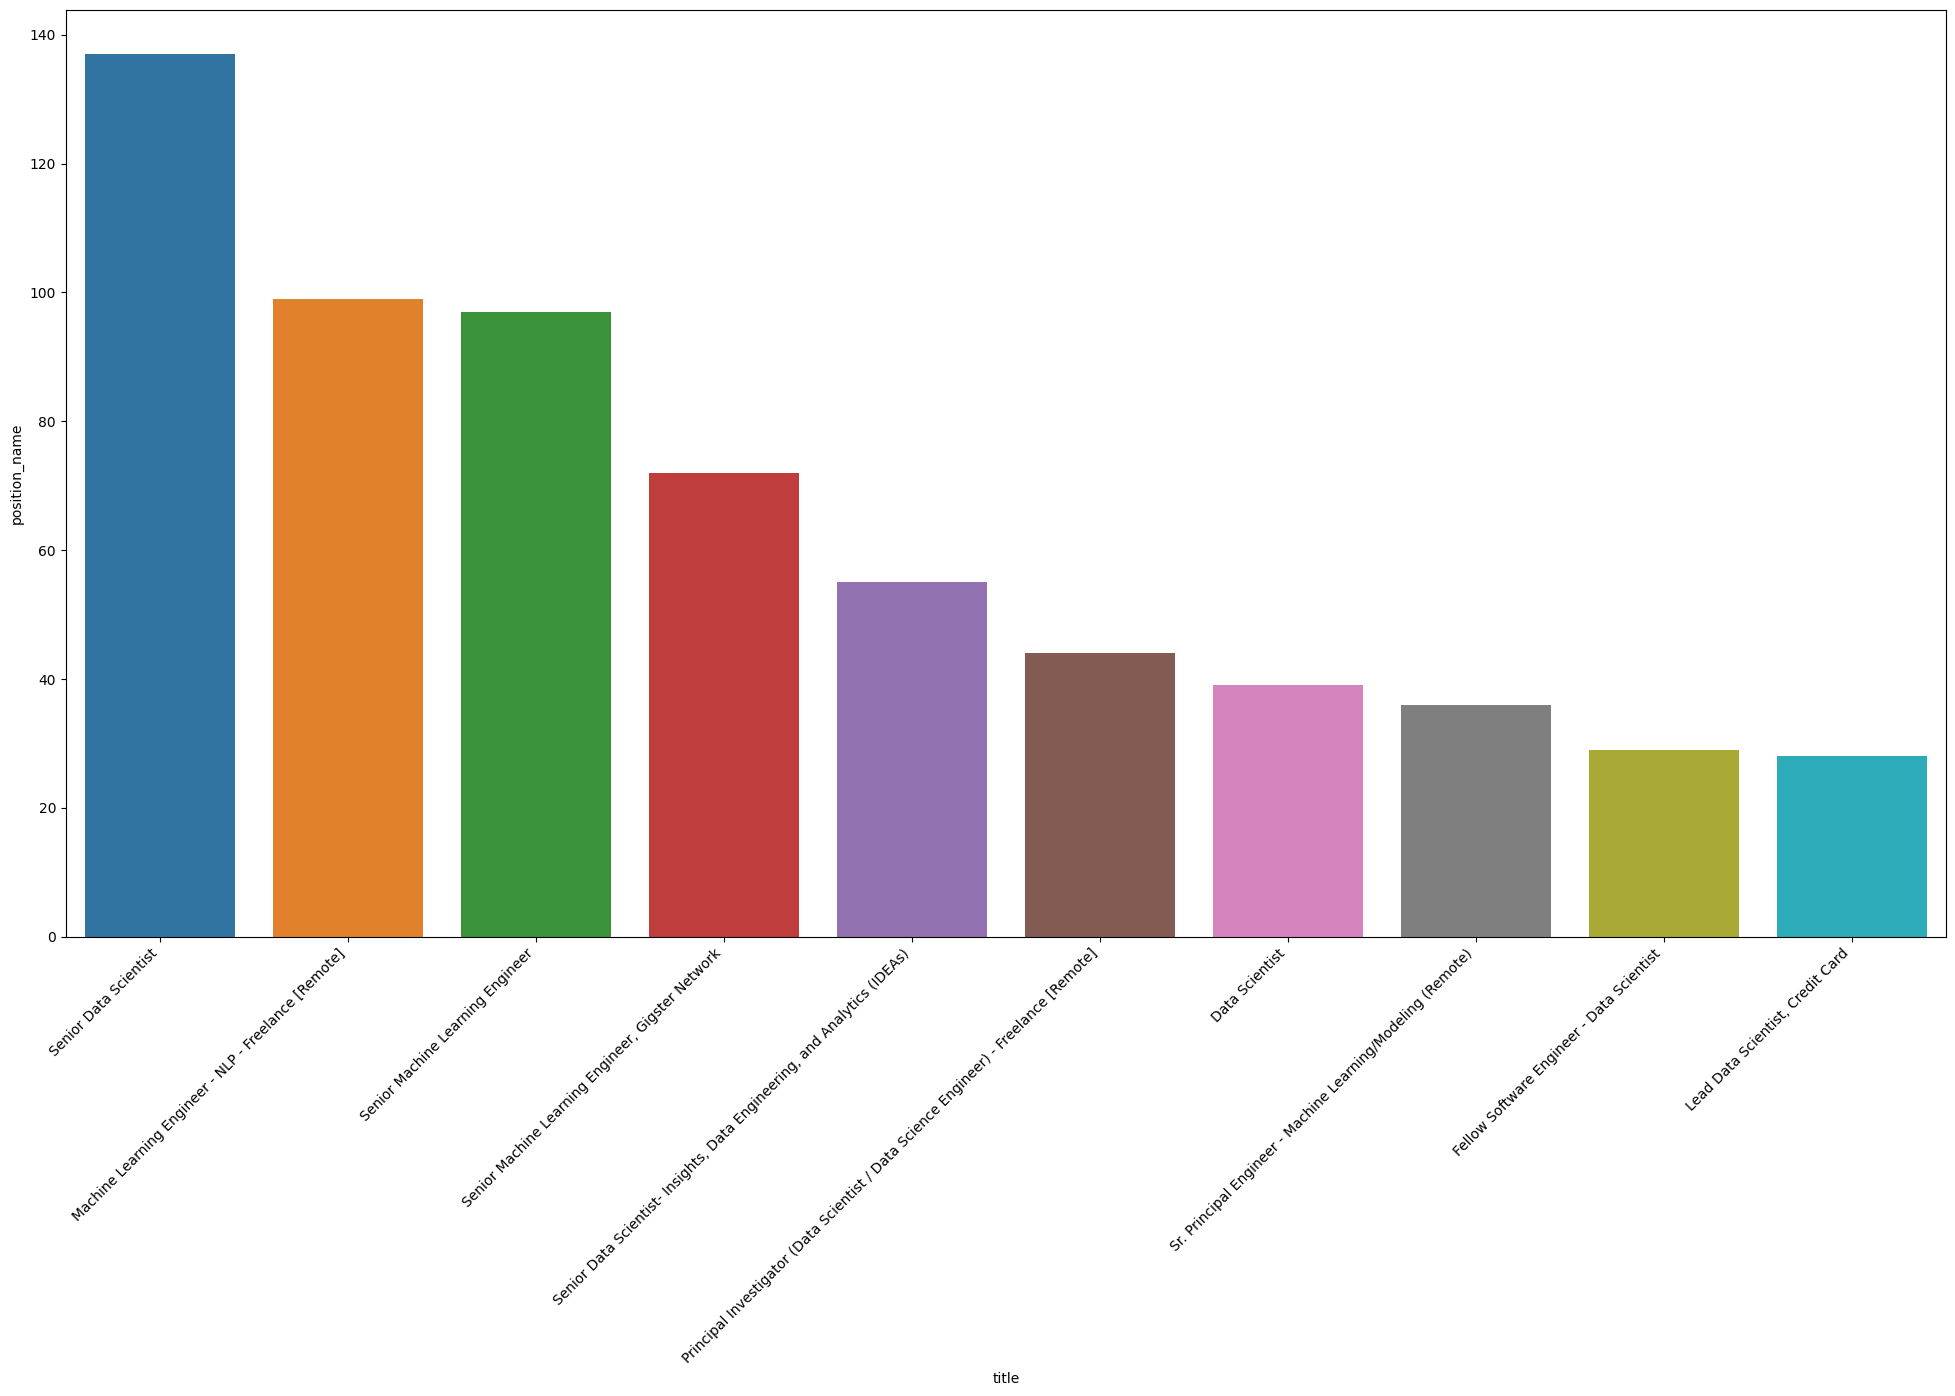

In [28]:
top_10_jobs_name = df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

Experiences required

In [29]:
df_target.groupby('experience_required').count()['title'].sort_values(ascending=False)

experience_required
Mid-Senior level    2001
Associate            102
Name: title, dtype: int64

All contract type

In [30]:
df_target.groupby('contract_type').count()['title'].sort_values(ascending=False)

contract_type
Full-time    2095
Contract        8
Name: title, dtype: int64

All different Function names

In [31]:
df_target.groupby('function_name').count()['title'].sort_values(ascending=False)

function_name
Engineering and Information Technology           1108
Other                                             254
Research, Analyst, and Information Technology     142
Information Technology                             98
Engineering                                        80
                                                 ... 
Information Technology and Marketing                1
Information Technology and Other                    1
Information Technology and Product Management       1
Information Technology and Project Management       1
Strategy/Planning                                   1
Name: title, Length: 88, dtype: int64

All different company sectors

In [32]:
df_target.groupby('company_sector').count()['title'].sort_values(ascending=False)

company_sector
Technology, Information and Internet                                                         349
Software Development                                                                         273
Staffing and Recruiting                                                                      170
IT Services and IT Consulting                                                                134
Business Consulting and Services                                                             119
                                                                                            ... 
Online Audio and Video Media and Retail                                                        1
Defense and Space Manufacturing, Government Relations Services, and Airlines and Aviation      1
Consumer Electronics                                                                           1
Real Estate                                                                                    1
IT Services and

All different locations

In [33]:
df_target.groupby('location').count()['title'].sort_values(ascending=False)

location
United States                                                614
San Francisco, CA                                            116
New York, NY                                                  93
Seattle, WA                                                   60
Boston, MA                                                    57
                                                            ... 
Kuala Lumpur, Federal Territory of Kuala Lumpur, Malaysia      1
Kyrgyzstan                                                     1
Lafayette, LA                                                  1
Lake County, IL                                                1
Łódź, Łódzkie, Poland                                          1
Name: title, Length: 335, dtype: int64

Example of description

In [28]:
df_target['description'].iloc[0]

"About the location Alcoa’s U.S. portfolio includes Alcoa's corporate headquarters (ACC), Alcoa's Technology Center (ATC), four smelters, hydroelectric power and a calcined coke plant. Every day is a new and exciting challenge at the Alcoa Technical Center in New Kensington, PA, just north of Pittsburgh; whether working virtually, on-site, or a hybrid of the two, we develop new technologies with our Breakthrough Technologies team that has the potential to impact the life of millions of people, and foster the sustainable footprint from Alcoa to the world. It was here where we developed the technology recently announced in partnership with Rio Tinto, called ELYSIS™, where we will produce aluminum with ZERO emission of greenhouse gases. In fact, we will actually be generating oxygen to our atmosphere during the aluminum production process– a revolution to the aluminum industry!About The Job Alcoa Technical Center (ATC) is the flagship light metal research center of Alcoa situated in New K

In [29]:
df_target['description'].iloc[1]

'The role: At Big Hat Biosciences our machine learning stack is tightly integrated with a high-throughput wetlab to rapidly design and validate ML-engineered antibodies. The Machine Learning Scientist* will work to advance the state of the art at each step in this integrated, iterative antibody optimization platform, improving the effectiveness with which it can be used to design new therapeutics to address unmet patient need.At Big Hat we believe in titles that commensurate with skill set, relative organizational impact, and value contribution; more experienced candidates are encouraged to apply, with the understanding that responsibilities and title would adjust as appropriate. Job Responsibilities Rapidly design, implement, and evaluate predictive machine learning models of diverse antibody biophysical properties, for dataset scales from hundreds to millions, to support Big Hat’s therapeutic portfolio.Develop and implement improved active learning / bayesian optimization methodologi

# Data Science

## Spacy personalized NER

In [21]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

In [22]:
#gensim
import gensim
from gensim import corpora

In [73]:
#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud

In [24]:
#Data loading/ Data manipulation

import numpy as np
import jsonlines

In [25]:
#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\55249\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
#warning
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Loading spaCy model

In [27]:
#nlp = spacy.load("en_core_web_lg")
nlp = spacy.load("en_core_web_sm")

In [28]:
skill_pattern_path = "jz_skill_patterns.jsonl"

In [29]:
#Entity Ruler
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

### Functions

In [30]:
#functions to get skilss

def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

### Preprocess

In [31]:
df_job['description']

0       DutiesWe encourage you to read this entire vac...
1       DutiesWe encourage you to read this entire vac...
2       CLO Virtual Fashion is a world leader in 3D ga...
3       Ready to join the AQ era?SandboxAQ is solving ...
4       Senior Data Scientist 160,000 - 180,000 + Equi...
                              ...                        
2648    Fuse is on a mission to disrupt healthcare. Ou...
2649    About Form EnergyAre you ready to rise to the ...
2650    About Form EnergyAre you ready to rise to the ...
2651    About Form EnergyAre you ready to rise to the ...
2652    About Form EnergyAre you ready to rise to the ...
Name: description, Length: 2653, dtype: object

In [32]:
#data = df_job.copy()
data = df_job.head(50)

In [33]:
clean = []
#for i in range(data.shape[0]):
for i in range(len(data.head(50))):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["description"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [34]:
clean

['dutieswe encourage read entire vacancy announcement prior submitting application associate education research scientist ad 1730 00 responsible assist developing implementing managing rigorous education research including education statistic large scale assessment using advanced quantitative method address significant question education science policy practice assist implementing large scale statistical study conducting scientific review 1 plan conducting rigorous education research evaluation statistic 2 plan analyzing data arising activity 3 scholarly publication related product based analysis assist preparation written product arising rigorous quantitative study convey study finding variety audience engaging dissemination outreach activity publishing scholarly work attending scientific conference consulting staff across department issue related research evaluation statistic assist monitoring federal grant contract support education research evaluation data collection large scale as

### Extract skilss

In [35]:
data['clean_description'] = clean
data["skills"] = data["clean_description"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,title,location,company_name,position_name,experience_required,contract_type,function_name,company_sector,description,link,now_datetime,clean_description,skills
0,"Associate Education Research Scientist, AD-173...","Wallops Island, VA",USAJOBS,"Associate Education Research Scientist, AD-173...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589288300,2023-04-29 03:15:45.101879,dutieswe encourage read entire vacancy announc...,"[material, security, publishing, support, sche..."
1,"Education Research Scientist, AD-1730-00, (TER...","Wallops Island, VA",USAJOBS,"Education Research Scientist, AD-1730-00, (TER...",Mid-Senior level,Full-time,Other,Human Resources Services,DutiesWe encourage you to read this entire vac...,https://www.linkedin.com/jobs/view/3589291042,2023-04-29 03:16:06.357202,dutieswe encourage read entire vacancy announc...,"[publishing, support, fingerprint, schedule, c..."
2,Research Scientist (Physics based Simulation /...,United States,CLO Virtual Fashion Inc.,Research Scientist (Physics based Simulation /...,Mid-Senior level,Full-time,Other,Information Technology & Services,CLO Virtual Fashion is a world leader in 3D ga...,https://www.linkedin.com/jobs/view/3529691030,2023-04-29 03:16:17.403721,clo virtual fashion world leader 3d garment te...,"[simulation, continuous integration, computer ..."
3,PhD Residency - PETs Research Scientist,United States,SandboxAQ,PhD Residency - PETs Research Scientist,Mid-Senior level,Full-time,Other,"Technology, Information and Internet",Ready to join the AQ era?SandboxAQ is solving ...,https://www.linkedin.com/jobs/view/3439427722,2023-04-29 03:16:28.338813,ready join aq era sandboxaq solving challengin...,"[collaboration, python, ml, computer science, ..."
4,Lead Data Scientist (ML),"Palo Alto, CA",Harnham,Lead Data Scientist (ML),Mid-Senior level,Full-time,Strategy/Planning,Software Development,"Senior Data Scientist 160,000 - 180,000 + Equi...",https://www.linkedin.com/jobs/view/3592018248,2023-04-29 03:15:33.901690,senior data scientist 160 000 180 000 equity r...,"[ml, security, time series, business, deployme..."


In [36]:
df_job.shape[0]

2653

## Visualizations

In [37]:
import plotly.express as px

In [38]:
import seaborn as sns

data_exploded = data.explode('skills')
count_data = data_exploded.groupby(['title', 'skills']).size().reset_index(name='count')
count_data

,title,skills,count
0,Applied Research Scientist,business,1
1,Applied Research Scientist,business intelligence,1
2,Applied Research Scientist,data visualization,1
3,Applied Research Scientist,design,1
4,Applied Research Scientist,marketing,1
...,...,...,...
617,Staff Software Engineer - Workday Learning (Re...,software,1
618,Staff Software Engineer - Workday Learning (Re...,support,1
619,Staff Software Engineer - Workday Learning (Re...,system integration,1
620,Staff Software Engineer - Workday Learning (Re...,system testing,1


In [ ]:
top_10_jobs_name = df_target.groupby('title').count()['position_name'].sort_values(ascending=False).head(10)
plt.figure(figsize=(20,10))
sns.barplot(x = top_10_jobs_name.index , y = top_10_jobs_name)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

In [61]:
fig = px.bar(count_data, x='title', y='count', color='skills', title='Skills by job title')
fig.update_layout(
    autosize=False,
    width=20*100,
    height=10*100
)
fig.show()

In [62]:
fig = px.histogram(
    data, x="title", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.update_layout(
    autosize=False,
    width=20*100,
    height=10*100
)
fig.show()

In [67]:
#Job_Category ='ALL'
Job_Category ='Senior Data Scientist'

In [68]:
Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["title"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.update_layout(
    autosize=False,
    width=20*100,
    height=10*70,
    xaxis_tickangle=45
)
fig.show()

In [69]:
Job_Category ='ALL'

Total_skills = []
if Job_Category != "ALL":
    fltr = data[data["title"] == Job_Category]["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)
else:
    fltr = data["skills"]
    for x in fltr:
        for i in x:
            Total_skills.append(i)

fig = px.histogram(
    x=Total_skills,
    labels={"x": "Skills"},
    title=f"{Job_Category} Distribution of Skills",
).update_xaxes(categoryorder="total descending")
fig.update_layout(
    autosize=False,
    width=20*100,
    height=10*70,
    xaxis_tickangle=45
)
fig.show()

In [84]:
sent = nlp(data["description"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [85]:
#Dependency Parsing
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [76]:
Job_Category = data["title"].unique()
Job_Category

array(['Associate Education Research Scientist, AD-1730-00, (Term NTE 3 Years) (Remote Eligible)',
       'Education Research Scientist, AD-1730-00, (TERM NTE 3 YEARS) (REMOTE ELIGIBLE)',
       'Research Scientist (Physics based Simulation / Computer Graphics), R&D',
       'PhD Residency - PETs Research Scientist',
       'Lead Data Scientist (ML)', 'Senior Data Scientist',
       'Senior Laravel Developer-Full Stack', 'Senior iOS Developer',
       'Master Data Scientist',
       'Research Scientist - CFD Modeler (Flexible)',
       'Research Scientist/Physicist',
       'PhD Residency - PQC Research Scientist',
       'Machine Learning Data Scientist', 'Research Scientist',
       'Applied Research Scientist',
       'Research Scientist - Software Engineering - Remote | WFH',
       'Data Scientist, Ecosystem',
       'Lead Data Engineer - Remote Opportunity',
       'Senior Machine Learning Engineer, Trust',
       'Sr Data Scientist at North Carolina & New Jersey- Hybrid Remote',

Text(0.5, 1.0, 'Most Used Words in Senior Data Scientist jobs')

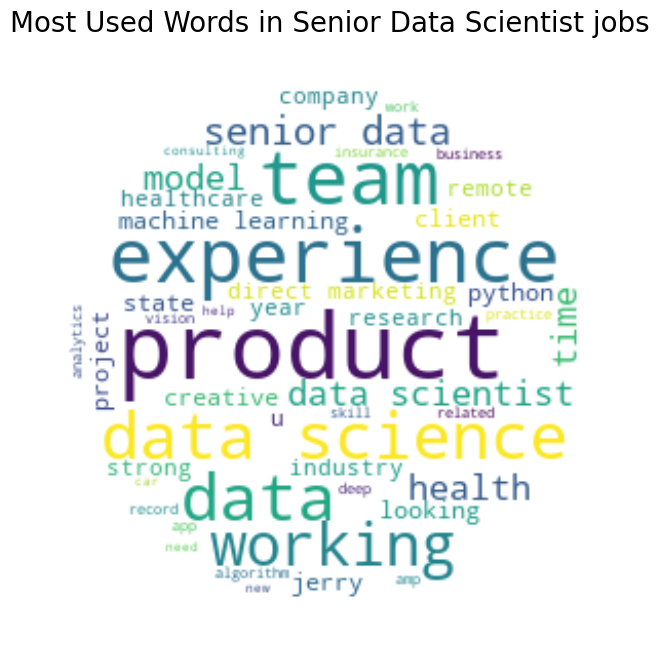

In [82]:
Job_Category ='Senior Data Scientist'

text = ""
for i in data[data["title"] == Job_Category]["clean_description"].values:
    text += i + " "

plt.figure(figsize=(8, 8))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=800,
    height=800,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} jobs", fontsize=20)

### Check the Match Score with one job and your skills

In [111]:
lowercase_list = [item.lower() for item in input_skills]
lowercase_list

['encourage', 'announcement', 'data science', 'sql']

In [90]:
data.iloc[0]['clean_description']

'dutieswe encourage read entire vacancy announcement prior submitting application associate education research scientist ad 1730 00 responsible assist developing implementing managing rigorous education research including education statistic large scale assessment using advanced quantitative method address significant question education science policy practice assist implementing large scale statistical study conducting scientific review 1 plan conducting rigorous education research evaluation statistic 2 plan analyzing data arising activity 3 scholarly publication related product based analysis assist preparation written product arising rigorous quantitative study convey study finding variety audience engaging dissemination outreach activity publishing scholarly work attending scientific conference consulting staff across department issue related research evaluation statistic assist monitoring federal grant contract support education research evaluation data collection large scale ass

In [95]:
input_job = data.iloc[0]['clean_description']

In [131]:
req_skills = ['publishing', 'Certificate', 'data science', 'sql']
resume_skills = unique_skills(get_skills(input_job))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"The current job requirement is {match}% matched to your skills")

The current job requirement is 25.0% matched to your skills


### Topic Modeling - LDA

In [168]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [169]:
documents = data['clean_description'].tolist()

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")


Top words for Topic #1: product, client, working, experience, data, direct, 000, marketing, python, model
Top words for Topic #2: team, research, work, ai2, member, disability, opportunity, people, year, value
Top words for Topic #3: data, experience, science, work, business, learning, scientist, team, skill, year
Top words for Topic #4: data, science, medium, customer, experience, 51, 84, solution, learning, team
Top words for Topic #5: research, data, experience, team, lsac, product, analysis, scientist, job, position


In [185]:
nested_list = data['skills'].tolist()
unique_list = list(set(sum(nested_list, [])))
documents = unique_list

# vectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(documents)

# LDA
num_topics = 5  # Número de tópicos desejados
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_model.fit(X)

# most relevant
feature_names = vectorizer.get_feature_names_out()
top_words = 10  # Número de palavras principais por tópico
for topic_idx, topic in enumerate(lda_model.components_):
    top_words_indices = topic.argsort()[:-top_words - 1:-1]
    top_words_list = [feature_names[i] for i in top_words_indices]
    print(f"Top words for Topic #{topic_idx + 1}: {', '.join(top_words_list)}")

Top words for Topic #1: database, testing, knowledge, relational, logistic, regression, decision, tree, pattern, recognition
Top words for Topic #2: knowledge, integration, management, intelligence, continuous, control, version, information, retrieval, domain
Top words for Topic #3: data, business, model, analysis, learning, computer, science, visualization, algorithm, design
Top words for Topic #4: engineering, language, natural, processing, code, quality, software, signal, digital, understanding
Top words for Topic #5: deployment, language, cryptographic, protocol, lambda, aws, user, interface, scripting, programming


## Extract years of experience required in description

### Using regex

In [28]:

# Define regular expression pattern to match the number of years
pattern = r'(\d+)\+?\s*(years|year|yrs|yr)'
matches = df_target['description'].apply(lambda x: re.findall(pattern, x, re.IGNORECASE))

In [29]:
matches

0                                                    []
1                              [(1, Year), (10, years)]
2                                          [(5, years)]
3                                          [(5, years)]
4                                          [(4, years)]
5                              [(6, years), (6, years)]
6                                          [(5, years)]
7                                          [(3, years)]
8     [(10, years), (4, years), (10, year), (3, year...
9                                          [(2, years)]
10                 [(5, years), (5, years), (5, years)]
11                                         [(2, years)]
12                                         [(4, years)]
13                                         [(8, years)]
14    [(31, years), (2, years), (7, years), (7, year...
15                             [(3, years), (5, years)]
16                                                   []
17                                              

In [30]:
# Extract the matched numbers and convert them to integers
matches.apply(lambda x: [int(match[0]) for match in x])

0                                    []
1                               [1, 10]
2                                   [5]
3                                   [5]
4                                   [4]
5                                [6, 6]
6                                   [5]
7                                   [3]
8                     [10, 4, 10, 3, 2]
9                                   [2]
10                            [5, 5, 5]
11                                  [2]
12                                  [4]
13                                  [8]
14            [31, 2, 7, 7, 7, 7, 3, 3]
15                               [3, 5]
16                                   []
17                                   []
18                                   []
19                                   []
20                                  [5]
21                                   []
22                                  [5]
23    [4, 5, 5, 7, 5, 3, 3, 5, 5, 5, 5]
24                                   []


In [32]:
df_target['description'][47]

'Volitiion IIT Inc. is an IT Service and Staffing firm based of Leesburg VA. We have hiring Top Talents to add to our growing team of Technology Professionals.We are looking for a Data Scientist to add to our team.Job Overview Scope of job:Gather relevant data and perform detailed analysis of driver allocation and routing data to develop predictive models for driver assignment, arrival/departure timing, truckload optimization, and route optimization. Work directly with the client to understand desired outcomes and business/technical constraints. Develop analytical models that validate proposed changes to business practices/procedures and participate in the presentation of results to client leadership.Required Work with stakeholders to identify key metrics and opportunities for improving business processes, products, and services Perform data mining, exploration, and analysis Create data visualizations, reports Design, train, and implement machine learning algorithms Leverage predictive